In [1]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth_voltage(x, y, frac=0.2):
    """
    LOESS 스무딩 후, 원래 x 지점에 대응하는 y_smooth 반환
    x, y: 1D numpy arrays
    """
    sm = lowess(y, x, frac=frac, return_sorted=True)
    xs, ys = sm[:,0], sm[:,1]
    return np.interp(x, xs, ys)


SINDy 계수 매트릭스:
             1  RH_a_norm  RH_c_norm  CurrentDensity     cycle  RH_a_norm^2  \
1          0.0        0.0        0.0             0.0 -0.000000          0.0   
Voltage    0.0        0.0        0.0             0.0  0.000000          0.0   
Voltage^2  0.0        0.0        0.0             0.0  0.000092          0.0   

           RH_a_norm RH_c_norm  RH_a_norm CurrentDensity  RH_a_norm cycle  \
1                          0.0                       0.0         0.001823   
Voltage                    0.0                       0.0        -0.000000   
Voltage^2                  0.0                       0.0        -0.000000   

           RH_c_norm^2  RH_c_norm CurrentDensity  RH_c_norm cycle  \
1                  0.0                       0.0             -0.0   
Voltage            0.0                       0.0              0.0   
Voltage^2          0.0                       0.0              0.0   

           CurrentDensity^2  CurrentDensity cycle   cycle^2  
1                   

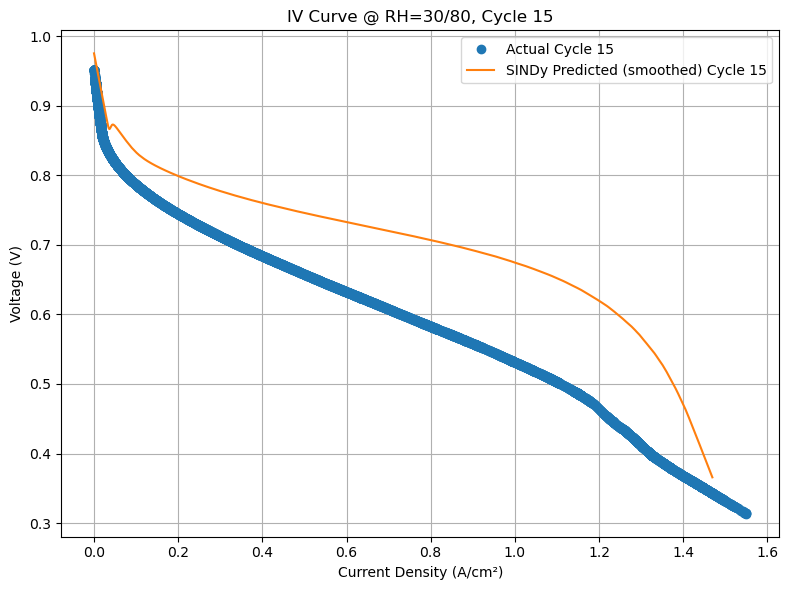

In [2]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# ------------------------------------------------------------------------------
# 1. 데이터 불러오기 · 전처리 (스무딩 포함)
# ------------------------------------------------------------------------------
all_dfs = []
for fp in glob.glob('RHa_*_RHc_*_*.csv'):
    df0 = pd.read_csv(fp, encoding='cp949')
    if 'Voltage(V)' not in df0.columns or 'Current(A)' not in df0.columns:
        continue

    # 전압·전류 컬럼 정리
    df = (
        df0[['Voltage(V)', 'Current(A)']]
        .dropna()
        .rename(columns={'Voltage(V)': 'Voltage'})
    )
    # 전류밀도 계산
    df['CurrentDensity'] = df['Current(A)'] / 25.0

    # LOESS 스무딩 적용
    df['Voltage'] = smooth_voltage(
        df['CurrentDensity'].values,
        df['Voltage'].values,
        frac=0.2
    )

    # 파일명에서 RH_a, RH_c, cycle 파싱
    m = re.search(r'RHa_(\d+)_RHc_(\d+)_(\d+)\.csv$', fp)
    if not m:
        continue
    df['RH_a']      = int(m.group(1))
    df['RH_c']      = int(m.group(2))
    df['cycle']     = int(m.group(3))
    # 0–1 정규화
    df['RH_a_norm'] = df['RH_a'] / 100.0
    df['RH_c_norm'] = df['RH_c'] / 100.0

    all_dfs.append(df[['Voltage','CurrentDensity','RH_a_norm','RH_c_norm','cycle']])

if not all_dfs:
    raise RuntimeError("데이터가 하나도 읽히지 않았습니다. 파일 패턴과 컬럼명을 확인하세요.")
df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------------------------------------------------------------
# 2. dV/dn 계산
# ------------------------------------------------------------------------------
df_all['dV_dn'] = (
    df_all
    .groupby(['CurrentDensity','RH_a_norm','RH_c_norm'])['Voltage']
    .diff()
)
df = df_all.dropna(subset=['dV_dn']).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 3. Θ(V) 라이브러리 (degree=3)
# ------------------------------------------------------------------------------
poly_V      = PolynomialFeatures(degree=2, include_bias=True)
Theta       = poly_V.fit_transform(df[['Voltage']])
theta_names = poly_V.get_feature_names_out(['Voltage'])

# ------------------------------------------------------------------------------
# 4. Φ(p) 라이브러리 (degree=2)
# ------------------------------------------------------------------------------
poly_p      = PolynomialFeatures(degree=2, include_bias=True)
Phi         = poly_p.fit_transform(df[['RH_a_norm','RH_c_norm','CurrentDensity','cycle']])
phi_names   = poly_p.get_feature_names_out(['RH_a_norm','RH_c_norm','CurrentDensity','cycle'])

# ------------------------------------------------------------------------------
# 5. 설계 행렬 Ψ 생성
# ------------------------------------------------------------------------------
n_theta, n_phi = Theta.shape[1], Phi.shape[1]
Psi            = np.einsum('ik,ij->ikj', Theta, Phi).reshape(len(df), -1)

# ------------------------------------------------------------------------------
# 6. Lasso 회귀 (동적 SINDy)
# ------------------------------------------------------------------------------
y     = df['dV_dn'].values
lasso = Lasso(alpha=1e-3, max_iter=100000, fit_intercept=False)
lasso.fit(Psi, y)
Xi    = lasso.coef_.reshape(n_theta, n_phi)

Xi_df = pd.DataFrame(Xi, index=theta_names, columns=phi_names)
print("SINDy 계수 매트릭스:")
print(Xi_df)

# ------------------------------------------------------------------------------
# 7. SINDy ΔV 예측 함수
# ------------------------------------------------------------------------------
def sindy_predict(V, c1, c2, J, n):
    # 상태 라이브러리 Θ
    th = poly_V.transform(pd.DataFrame({'Voltage':[V]}))[0]
    # 파라미터 라이브러리 Φ
    ph = poly_p.transform(pd.DataFrame({
        'RH_a_norm':     [c1],
        'RH_c_norm':     [c2],
        'CurrentDensity':[J],
        'cycle':         [n]
    }))[0]
    # 외적 후 vectorize
    psi = np.outer(th, ph).reshape(-1)
    return float(psi @ Xi.flatten())

# ------------------------------------------------------------------------------
# 8. IV 커브 예측 및 플롯 (RH=30/80, cycle=0 → 15)
# ------------------------------------------------------------------------------
c1, c2       = 0.30, 0.80
target_cycle = 15

# 조건에 맞는 데이터만, 사이클·전류밀도 기준 정렬
df_cond = (
    df_all[(df_all['RH_a_norm']==c1)&(df_all['RH_c_norm']==c2)]
    .sort_values(['cycle','CurrentDensity'])
    .reset_index(drop=True)
)

# 초기 cycle=0
df_init = df_cond[df_cond['cycle']==0]
V_pred  = df_init['Voltage'].values.copy()
J_vals  = df_init['CurrentDensity'].values.copy()

# 누적 예측
for n in range(0, target_cycle):
    dV     = np.array([
        sindy_predict(V_pred[i], c1, c2, J_vals[i], n+1)
        for i in range(len(V_pred))
    ])
    V_pred = V_pred + dV

# 실제 15사이클
df15 = df_cond[df_cond['cycle']==target_cycle]

# 스무딩된 예측 커브
V_pred_smooth = smooth_voltage(J_vals, V_pred, frac=0.2)

# 플롯
plt.figure(figsize=(8,6))
plt.plot(df15['CurrentDensity'], df15['Voltage'],
         'o', label=f'Actual Cycle {target_cycle}')
plt.plot(J_vals, V_pred_smooth,
         '-', label=f'SINDy Predicted (smoothed) Cycle {target_cycle}')
plt.xlabel('Current Density (A/cm²)')
plt.ylabel('Voltage (V)')
plt.title(f'IV Curve @ RH={int(c1*100)}/{int(c2*100)}, Cycle {target_cycle}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SINDy 계수 매트릭스:
             1  RH_a_norm  RH_c_norm  CurrentDensity     cycle  RH_a_norm^2  \
1          0.0        0.0        0.0             0.0 -0.000000          0.0   
Voltage    0.0        0.0        0.0             0.0  0.000000          0.0   
Voltage^2  0.0        0.0        0.0             0.0  0.000076          0.0   
Voltage^3  0.0        0.0        0.0             0.0  0.000000          0.0   

           RH_a_norm RH_c_norm  RH_a_norm CurrentDensity  RH_a_norm cycle  \
1                          0.0                       0.0         0.001717   
Voltage                    0.0                       0.0        -0.000000   
Voltage^2                  0.0                       0.0        -0.000000   
Voltage^3                  0.0                       0.0        -0.000000   

           RH_c_norm^2  RH_c_norm CurrentDensity  RH_c_norm cycle  \
1                  0.0                       0.0             -0.0   
Voltage            0.0                       0.0              0.0

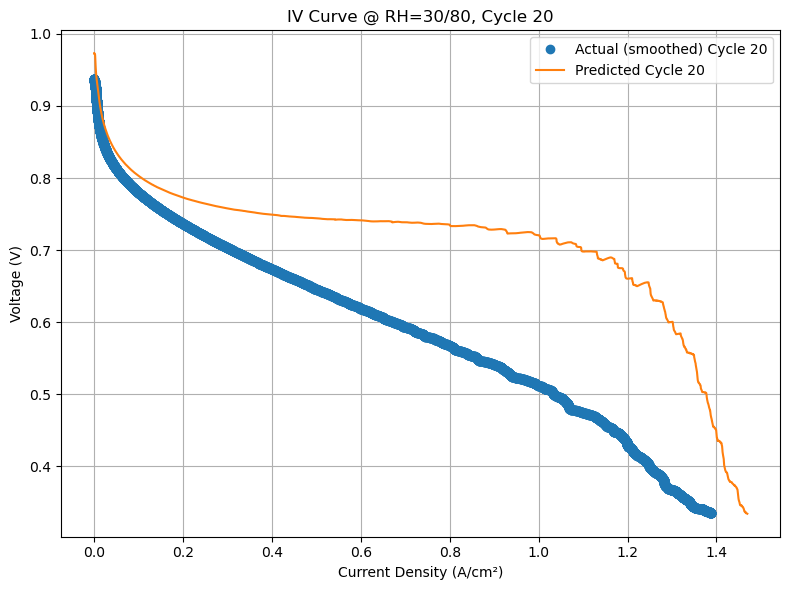

In [6]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# ------------------------------------------------------------------------------
# 스무딩 함수: pandas rolling mean 기반 (statsmodels 없이)
# ------------------------------------------------------------------------------
def smooth_voltage(x, y, frac=0.2):
    """
    x, y: 1D numpy arrays (정렬된 상태여야 함)
    frac: 스무딩 윈도우 비율 (0 < frac <= 1)
    returns: y_smooth (same shape as y)
    """
    window = max(3, int(len(y) * frac))
    return pd.Series(y).rolling(window, center=True, min_periods=1).mean().values

# ------------------------------------------------------------------------------
# 1. 데이터 불러오기 · 전처리 (LOESS-like 스무딩 포함)
# ------------------------------------------------------------------------------
all_dfs = []
for fp in glob.glob('RHa_*_RHc_*_*.csv'):
    df0 = pd.read_csv(fp, encoding='cp949')
    if 'Voltage(V)' not in df0.columns or 'Current(A)' not in df0.columns:
        continue

    # 전압·전류 컬럼 정리
    df = (
        df0[['Voltage(V)', 'Current(A)']]
        .dropna()
        .rename(columns={'Voltage(V)': 'Voltage'})
    )
    # 전류밀도 계산
    df['CurrentDensity'] = df['Current(A)'] / 25.0

    # 스무딩용 정렬
    df = df.sort_values('CurrentDensity').reset_index(drop=True)
    # Voltage 스무딩
    df['Voltage'] = smooth_voltage(
        df['CurrentDensity'].values,
        df['Voltage'].values,
        frac=0.2
    )

    # 파일명에서 RH_a, RH_c, cycle 추출
    m = re.search(r'RHa_(\d+)_RHc_(\d+)_(\d+)\.csv$', fp)
    if not m:
        continue
    df['RH_a']      = int(m.group(1))
    df['RH_c']      = int(m.group(2))
    df['cycle']     = int(m.group(3))
    # 0–1 정규화
    df['RH_a_norm'] = df['RH_a'] / 100.0
    df['RH_c_norm'] = df['RH_c'] / 100.0

    # 최종 컬럼만 append
    all_dfs.append(df[['Voltage','CurrentDensity','RH_a_norm','RH_c_norm','cycle']])

if not all_dfs:
    raise RuntimeError("데이터가 하나도 읽히지 않았습니다. 파일 패턴과 컬럼명을 확인하세요.")
df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------------------------------------------------------------
# 2. dV/dn 계산
# ------------------------------------------------------------------------------
df_all['dV_dn'] = (
    df_all
    .groupby(['CurrentDensity','RH_a_norm','RH_c_norm'])['Voltage']
    .diff()
)
df = df_all.dropna(subset=['dV_dn']).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 3. Θ(V) 라이브러리 (degree=3)
# ------------------------------------------------------------------------------
poly_V      = PolynomialFeatures(degree=3, include_bias=True)
Theta       = poly_V.fit_transform(df[['Voltage']])
theta_names = poly_V.get_feature_names_out(['Voltage'])

# ------------------------------------------------------------------------------
# 4. Φ(p) 라이브러리 (degree=2)
# ------------------------------------------------------------------------------
poly_p      = PolynomialFeatures(degree=2, include_bias=True)
Phi         = poly_p.fit_transform(df[['RH_a_norm','RH_c_norm','CurrentDensity','cycle']])
phi_names   = poly_p.get_feature_names_out(['RH_a_norm','RH_c_norm','CurrentDensity','cycle'])

# ------------------------------------------------------------------------------
# 5. 설계 행렬 Ψ 생성
# ------------------------------------------------------------------------------
n_theta, n_phi = Theta.shape[1], Phi.shape[1]
Psi            = np.einsum('ik,ij->ikj', Theta, Phi).reshape(len(df), -1)

# ------------------------------------------------------------------------------
# 6. Lasso 회귀
# ------------------------------------------------------------------------------
y     = df['dV_dn'].values
lasso = Lasso(alpha=1e-3, max_iter=100000, fit_intercept=False)
lasso.fit(Psi, y)
Xi    = lasso.coef_.reshape(n_theta, n_phi)

Xi_df = pd.DataFrame(Xi, index=theta_names, columns=phi_names)
print("SINDy 계수 매트릭스:")
print(Xi_df)

# ------------------------------------------------------------------------------
# 7. SINDy ΔV 예측 함수
# ------------------------------------------------------------------------------
def sindy_predict(V, rh_a, rh_c, J, cycle):
    th  = poly_V.transform(pd.DataFrame({'Voltage':[V]}))[0]
    ph  = poly_p.transform(pd.DataFrame({
        'RH_a_norm':     [rh_a],
        'RH_c_norm':     [rh_c],
        'CurrentDensity':[J],
        'cycle':         [cycle]
    }))[0]
    psi = np.outer(th, ph).reshape(-1)
    return float(psi @ Xi.flatten())

# ------------------------------------------------------------------------------
# 8. IV 커브 예측 및 플롯 (RH=30/80, cycle=0 → 15) — 모두 스무딩된 데이터 기준
# ------------------------------------------------------------------------------
c1, c2       = 0.30, 0.80
target_cycle = 20

# 조건 필터링 + 정렬
df_cond = (
    df_all[(df_all['RH_a_norm']==c1)&(df_all['RH_c_norm']==c2)]
    .sort_values(['cycle','CurrentDensity'])
    .reset_index(drop=True)
)

# 초기 cycle=0 (스무딩된 전압)
df_init = df_cond[df_cond['cycle']==0]
V_pred  = df_init['Voltage'].values.copy()
J_vals  = df_init['CurrentDensity'].values.copy()

# 누적 예측 (스무딩된 V_pred를 기반으로 ΔV를 구함)
for n in range(0, target_cycle):
    dV     = np.array([
        sindy_predict(V_pred[i], c1, c2, J_vals[i], n+1)
        for i in range(len(V_pred))
    ])
    V_pred = V_pred + dV

# 실제 15사이클 (이미 스무딩된 df_cond 사용)
df15 = df_cond[df_cond['cycle']==target_cycle]

# 스무딩 검증 플롯: 실제 vs 예측
plt.figure(figsize=(8,6))
plt.plot(df15['CurrentDensity'], df15['Voltage'],
         'o', label=f'Actual (smoothed) Cycle {target_cycle}')
plt.plot(J_vals, V_pred,
         '-', label=f'Predicted Cycle {target_cycle}')
plt.xlabel('Current Density (A/cm²)')
plt.ylabel('Voltage (V)')
plt.title(f'IV Curve @ RH={int(c1*100)}/{int(c2*100)}, Cycle {target_cycle}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\DKU3\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+00, tolerance: 8.673e-04
  model = cd_fast.enet_coordinate_descent(


SINDy 계수 매트릭스:
             1  RH_a_norm  RH_c_norm  CurrentDensity     cycle  RH_a_norm^2  \
1         -0.0       -0.0       -0.0            -0.0 -0.001134         -0.0   
Voltage   -0.0       -0.0       -0.0            -0.0 -0.000000         -0.0   
Voltage^2 -0.0       -0.0       -0.0            -0.0 -0.000000         -0.0   
Voltage^3 -0.0       -0.0       -0.0            -0.0  0.000000         -0.0   
Voltage^4 -0.0       -0.0       -0.0            -0.0  0.000000         -0.0   

           RH_a_norm RH_c_norm  RH_a_norm CurrentDensity  RH_a_norm cycle  \
1                         -0.0                      -0.0             -0.0   
Voltage                   -0.0                      -0.0             -0.0   
Voltage^2                 -0.0                      -0.0             -0.0   
Voltage^3                 -0.0                      -0.0              0.0   
Voltage^4                 -0.0                      -0.0              0.0   

           RH_c_norm^2  ...  RH_c_norm^3  RH_c_

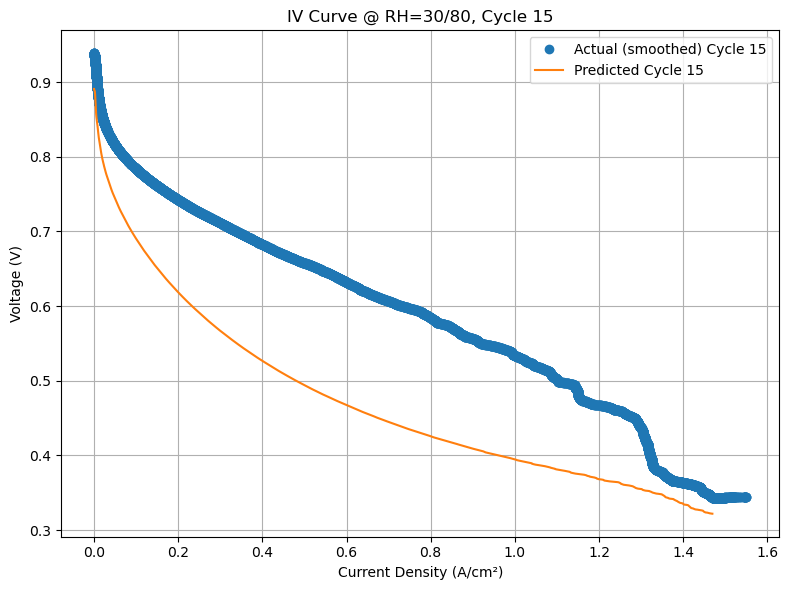

In [1]:
#사이클 번호 수정

import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# ------------------------------------------------------------------------------
# 스무딩 함수: pandas rolling mean 기반 (statsmodels 없이)
# ------------------------------------------------------------------------------
def smooth_voltage(x, y, frac=0.2):
    window = max(3, int(len(y) * frac))
    return pd.Series(y).rolling(window, center=True, min_periods=1).mean().values

# ------------------------------------------------------------------------------
# 1. 데이터 불러오기 · 전처리 (LOESS-like 스무딩 포함)
# ------------------------------------------------------------------------------
all_dfs = []
for fp in glob.glob('RHa_*_RHc_*_*.csv'):
    df0 = pd.read_csv(fp, encoding='cp949')
    if 'Voltage(V)' not in df0.columns or 'Current(A)' not in df0.columns:
        continue

    df = (
        df0[['Voltage(V)', 'Current(A)']]
        .dropna()
        .rename(columns={'Voltage(V)': 'Voltage'})
    )
    df['CurrentDensity'] = df['Current(A)'] / 25.0

    # 스무딩용 정렬 후 스무딩
    df = df.sort_values('CurrentDensity').reset_index(drop=True)
    df['Voltage'] = smooth_voltage(
        df['CurrentDensity'].values,
        df['Voltage'].values,
        frac=0.2
    )

    # 파일명에서 RH_a, RH_c, cycle 추출
    m = re.search(r'RHa_(\d+)_RHc_(\d+)_(\d+)\.csv$', fp)
    if not m:
        continue
    df['RH_a']  = int(m.group(1))
    df['RH_c']  = int(m.group(2))
    df['cycle'] = int(m.group(3))

    # 0–1 정규화
    df['RH_a_norm'] = df['RH_a'] / 100.0
    df['RH_c_norm'] = df['RH_c'] / 100.0

    all_dfs.append(df[['Voltage','CurrentDensity','RH_a_norm','RH_c_norm','cycle']])

if not all_dfs:
    raise RuntimeError("데이터가 하나도 읽히지 않았습니다. 파일 패턴과 컬럼명을 확인하세요.")
df_all = pd.concat(all_dfs, ignore_index=True)

# ------------------------------------------------------------------------------
# 2. dV/dn 계산 (정렬 후 forward diff: V_{n+1}-V_n → cycle=0..N-1 모두 학습에 포함)
# ------------------------------------------------------------------------------
df_all = df_all.sort_values(
    ['RH_a_norm','RH_c_norm','CurrentDensity','cycle']
).reset_index(drop=True)

keys = ['RH_a_norm','RH_c_norm','CurrentDensity']
df_all['dV_dn'] = df_all.groupby(keys)['Voltage'].shift(-1) - df_all['Voltage']

# 학습용 데이터프레임(마지막 사이클 제외)
df = df_all.dropna(subset=['dV_dn']).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 3. Θ(V) 라이브러리 (degree=3)
# ------------------------------------------------------------------------------
poly_V      = PolynomialFeatures(degree=4, include_bias=True)
Theta       = poly_V.fit_transform(df[['Voltage']])
theta_names = poly_V.get_feature_names_out(['Voltage'])

# ------------------------------------------------------------------------------
# 4. Φ(p) 라이브러리 (degree=2)
# ------------------------------------------------------------------------------
poly_p    = PolynomialFeatures(degree=3, include_bias=True)
Phi       = poly_p.fit_transform(df[['RH_a_norm','RH_c_norm','CurrentDensity','cycle']])
phi_names = poly_p.get_feature_names_out(['RH_a_norm','RH_c_norm','CurrentDensity','cycle'])

# ------------------------------------------------------------------------------
# 5. 설계 행렬 Ψ 생성
# ------------------------------------------------------------------------------
n_theta, n_phi = Theta.shape[1], Phi.shape[1]
Psi            = np.einsum('ik,ij->ikj', Theta, Phi).reshape(len(df), -1)

# ------------------------------------------------------------------------------
# 6. Lasso 회귀
# ------------------------------------------------------------------------------
y     = df['dV_dn'].values
lasso = Lasso(alpha=1e-3, max_iter=100000, fit_intercept=False)
lasso.fit(Psi, y)
Xi    = lasso.coef_.reshape(n_theta, n_phi)

Xi_df = pd.DataFrame(Xi, index=theta_names, columns=phi_names)
print("SINDy 계수 매트릭스:")
print(Xi_df)

# ------------------------------------------------------------------------------
# 7. SINDy ΔV 예측 함수 (학습과 동일하게 cycle=n을 입력)
# ------------------------------------------------------------------------------
def sindy_predict(V, rh_a, rh_c, J, cycle):
    th  = poly_V.transform(pd.DataFrame({'Voltage':[V]}))[0]
    ph  = poly_p.transform(pd.DataFrame({
        'RH_a_norm':[rh_a],
        'RH_c_norm':[rh_c],
        'CurrentDensity':[J],
        'cycle':[cycle]
    }))[0]
    psi = np.outer(th, ph).reshape(-1)
    return float(psi @ Xi.flatten())

# ------------------------------------------------------------------------------
# 8. IV 커브 예측 및 플롯 (RH=30/80, cycle=0 → target_cycle)
# ------------------------------------------------------------------------------
c1, c2       = 0.30, 0.80
target_cycle = 15

df_cond = (
    df_all[(df_all['RH_a_norm']==c1)&(df_all['RH_c_norm']==c2)]
    .sort_values(['cycle','CurrentDensity'])
    .reset_index(drop=True)
)

# 초기 cycle=0 전압
df_init = df_cond[df_cond['cycle']==0]
V_pred  = df_init['Voltage'].values.copy()
J_vals  = df_init['CurrentDensity'].values.copy()

# 누적 예측: 학습과 동일하게 cycle=n 사용
for n in range(0, target_cycle):
    dV     = np.array([
        sindy_predict(V_pred[i], c1, c2, J_vals[i], n)   # <-- n
        for i in range(len(V_pred))
    ])
    V_pred = V_pred + dV

# 실제 target_cycle
df_tgt = df_cond[df_cond['cycle']==target_cycle]

plt.figure(figsize=(8,6))
plt.plot(df_tgt['CurrentDensity'], df_tgt['Voltage'],
         'o', label=f'Actual (smoothed) Cycle {target_cycle}')
plt.plot(J_vals, V_pred, '-', label=f'Predicted Cycle {target_cycle}')
plt.xlabel('Current Density (A/cm²)')
plt.ylabel('Voltage (V)')
plt.title(f'IV Curve @ RH={int(c1*100)}/{int(c2*100)}, Cycle {target_cycle}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
